<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/ARIMA_forecacst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb

In [3]:
!wandb login

wandb: Currently logged in as: krankile (use `wandb login --relogin` to force relogin)


##General setup

In [4]:
%%capture
!pip install pmdarima

In [5]:
%%capture
!cd npmf && git pull

import os
import pickle
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import pmdarima as pm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_df_artifact
from npmf.utils.data import test_start_pd
from npmf.utils.measurement import mape

In [6]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
np.random.seed(420)

# Let's get the data and split into training and testing 😂✨KAWAIII ^^✨



In [9]:
data = get_df_artifact("stock-oil-final:v3", "master-test")
data = data[data.date > "01.01.2000"]

wandb: Currently logged in as: krankile (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact stock-oil-final:v3, 82.95MB. 1 files... Done. 0:0:0


In [10]:
#trn = data[(data.date >= "2018-10-01") & (data.date < test_start_pd)].copy()
trn = data[(data.date < test_start_pd)].copy()
tst = data[data.date >= test_start_pd].copy()

tst["obs_number"] = tst.groupby("ticker").date.rank(method='first', ascending=True).astype(int)
tst = tst[tst.obs_number <= 20]

tickers = set(trn.ticker.unique()) & set(tst.ticker.unique())

trn.shape, tst.shape

((2761377, 5), (19898, 6))

## Decide the length of lags that should be used for training the ARIMA models

4916

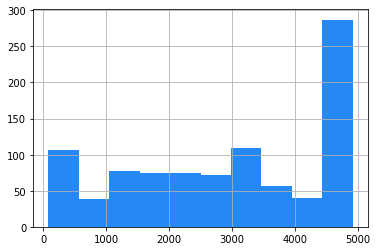

In [11]:
# Measure the length of series for all series
trn.groupby("ticker").count().date.hist()
trn.groupby("ticker").count().date.max()

In [12]:
# List of lags to test: 1 month, 2 months, 1 quarter, 2 quarters, 3 quarters, 1 year -> 20 years
lags = [20, 40] + list(range(60, 60*4, 60)) + list(range(240, 5000, 240))

len(lags)

25

In [22]:
# Choose a subset of the 934 tickers to test for
ticker_subset = np.random.choice(np.array(list(tickers)), size=50, replace=False)
len(ticker_subset)

50

In [27]:
# Create the validation set
traval = trn[trn.ticker.isin(ticker_subset)].copy()
print(traval.shape)
traval["obs_number"] = traval.groupby("ticker").date.rank(method='first', ascending=False).astype(int)

val = traval[traval.obs_number <= 20]
val.head()

(150918, 5)


,ticker,date,market_cap,close_price,currency,obs_number
47432,000985.SZ,2018-12-03,260417147.300793,2.008779,USD,20
47433,000985.SZ,2018-12-04,266893136.824546,2.058733,USD,19
47434,000985.SZ,2018-12-05,262509301.782744,2.024918,USD,18
47435,000985.SZ,2018-12-06,255827774.064171,1.973378,USD,17
47436,000985.SZ,2018-12-07,256325317.533062,1.977216,USD,16


In [28]:
train = traval[traval.obs_number > 20].copy()
train["obs_number"] = train.groupby("ticker").date.rank(method='first', ascending=False).astype(int)

train.head()

,ticker,date,market_cap,close_price,currency,obs_number
42973,000985.SZ,2000-07-26,310848350.161843,2.39779,USD,4459
42974,000985.SZ,2000-07-27,299053060.041307,2.306804,USD,4458
42975,000985.SZ,2000-07-28,299188346.981665,2.307848,USD,4457
42976,000985.SZ,2000-07-31,295723016.716591,2.281117,USD,4456
42977,000985.SZ,2000-08-01,297543122.191621,2.295157,USD,4455


In [16]:
def calculate_mean_mapes(ls, tcks):
    mean_mapes = []

    it = tqdm(total=len(ls)*len(tcks))

    for lag in ls:
        it.set_postfix(dict(lag=lag))
        mapes = []
        for ticker in tcks:
            series = train.loc[(train.ticker == ticker) & (train.obs_number <= lag), ["date", "market_cap"]].set_index("date").squeeze()

            mod = pm.arima.AutoARIMA(seasonal=False)
            mod.fit(series)

            forecast = mod.predict(20)
            actual = val.loc[(val.ticker == ticker), ["date", "market_cap"]].set_index("date").squeeze()
            mapes.append(mape(actual, forecast))
            it.update()

        mean_mapes.append(np.mean(mapes))

    return mean_mapes

In [ ]:
import cProfile

cmd = lambda: calculate_mean_mapes(lags[:2], ticker_subset[:20])

cProfile.run("calculate_mean_mapes(lags[:2], ticker_subset[:20])")

In [18]:
mmapes = calculate_mean_mapes(lags[::2], ticker_subset[:20])

100%|██████████| 260/260 [1:25:41<00:00, 19.77s/it, lag=4800]


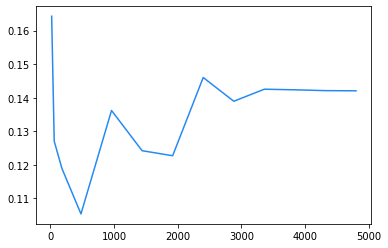

In [21]:
plt.plot(lags[::2], mmapes);

In [ ]:
# Do a more thorough search around the optimal above

mmapes = calculate_mean_mapes(lags[1:9], ticker_subset)


  6%|▋         | 26/400 [00:27<08:06,  1.30s/it, lag=40]


## Train ARIMA models on last quarter of 2018 🎯

And upload the result to WandB


In [ ]:
trained_models = dict()

for ticker in tqdm(tickers):

    series = trn.loc[trn.ticker == ticker, ["date", "market_cap"]].set_index("date").squeeze()
    
    mod = pm.arima.AutoARIMA()
    mod.fit(series)

    trained_models[ticker] = mod

In [ ]:
filename = "arima-trained-1Q.pickle"

with open(filename, mode="wb") as f:
    pickle.dump(trained_models, f)

with wb.init(project="master-test") as run:
    art = wb.Artifact(filename.split(".")[0], type="model")
    art.add_file(filename)

    run.log_artifact(art)
    

## Predict for first month of 2019

In [ ]:
# outdf = pd.DataFrame(columns=[f"V{i+1}" for i in range(20)], index=tickers, dtype=np.float64)

ob_num = list(range(1, 21))
out = dict(ticker=[], market_cap=[], obs_number=[])

for ticker, model in tqdm(trained_models.items()):
    forec = model.predict(20)
    ts = [ticker] * 20

    out["ticker"].extend(ts)
    out["market_cap"].extend(forec)
    out["obs_number"].extend(ob_num)

forec_df = pd.DataFrame(out)

forec_df

100%|██████████| 933/933 [00:03<00:00, 273.80it/s]


,ticker,market_cap,obs_number
0,CSAN3.SA,3.517287e+09,1
1,CSAN3.SA,3.517287e+09,2
2,CSAN3.SA,3.517287e+09,3
3,CSAN3.SA,3.517287e+09,4
4,CSAN3.SA,3.517287e+09,5
...,...,...,...
18655,OANDO.LG,2.024660e+08,16
18656,OANDO.LG,2.024660e+08,17
18657,OANDO.LG,2.024660e+08,18
18658,OANDO.LG,2.024660e+08,19


In [ ]:
errors = (forec_df.set_index(["ticker", "obs_number"]) - tst.set_index(["ticker", "obs_number"])).drop(columns=["close_price", "currency", "date"]).dropna()

In [ ]:
errors.abs().groupby("ticker").mean().mean()

market_cap    3.680191e+08
dtype: float64